In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("../../")

In [3]:
import eventx
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
import io

from pathlib import Path
from itertools import chain, accumulate

from eventx.predictors.predictor_utils import load_predictor
from eventx.models.model_utils import batched_predict_json
from eventx.predictors import snorkel_predictor, smartdata_predictor
from eventx.util import scorer
from eventx.util import utils
from eventx.util import evaluate
from eventx import SD4M_RELATION_TYPES, ROLE_LABELS

from allennlp.predictors import Predictor

In [4]:
from typing import List

In [5]:
CUDA_DEVICE = -1  # or -1 if no GPU is available

In [6]:
# Change paths
DATASET_PATH = "../../data/daystream_corpus/test/test_sd4m_with_events.jsonl"
PREDICTOR_NAME = "snorkel-eventx-predictor"
# PREDICTOR_NAME = "smartdata-eventx-predictor"

## Load the test data, models and do predictions

Filter documents that do not contain any entity of type trigger as they are not relevant for the event extraction task.

In [7]:
test_docs = evaluate.load_test_data(DATASET_PATH)

In [8]:
model_base_path = Path("../../data/runs/")
model_names = [
    "snorkel_bert_gold",
    "snorkel_bert_daystream",
    "snorkel_bert_merged"
]

In [9]:
predicted_docs = {}
for model_name in model_names:
    predictor = load_predictor(model_base_path.joinpath(model_name), PREDICTOR_NAME, CUDA_DEVICE)
    predicted_docs[model_name] = batched_predict_json(predictor=predictor, examples=test_docs)

## Conventional evaluation using sklearn toolkit
We simply consider the trigger & role label sequences disregarding the correctness of the corresponding trigger label when evaluating the argument roles to use the sklearn toolkit.

In [10]:
trigger_y_pred, arg_y_pred = {}, {}
for model_name in model_names:
    label_arrays = evaluate.get_label_arrays(test_docs, predicted_docs[model_name])
    trigger_y_true, trigger_y_pred[model_name] = label_arrays["trigger_y_true"], label_arrays["trigger_y_pred"]
    arg_y_true, arg_y_pred[model_name] = label_arrays["arg_y_true"], label_arrays["arg_y_pred"]

### Trigger classification

#### Model trained with SD4M gold training data

In [11]:
print(sklearn.metrics.classification_report(trigger_y_true, trigger_y_pred["snorkel_bert_gold"], SD4M_RELATION_TYPES[:-1]))

                        precision    recall  f1-score   support

              Accident       0.75      0.67      0.71         9
         CanceledRoute       1.00      0.80      0.89        10
          CanceledStop       1.00      1.00      1.00         3
                 Delay       1.00      1.00      1.00         2
           Obstruction       0.92      1.00      0.96        12
RailReplacementService       1.00      0.80      0.89         5
            TrafficJam       0.88      0.88      0.88        16

             micro avg       0.91      0.86      0.88        57
             macro avg       0.94      0.88      0.90        57
          weighted avg       0.91      0.86      0.88        57



In [12]:
print(sklearn.metrics.classification_report(trigger_y_true, trigger_y_pred["snorkel_bert_daystream"], SD4M_RELATION_TYPES[:-1]))

                        precision    recall  f1-score   support

              Accident       0.89      0.89      0.89         9
         CanceledRoute       1.00      0.70      0.82        10
          CanceledStop       1.00      1.00      1.00         3
                 Delay       1.00      1.00      1.00         2
           Obstruction       0.85      0.92      0.88        12
RailReplacementService       1.00      0.60      0.75         5
            TrafficJam       0.87      0.81      0.84        16

             micro avg       0.90      0.82      0.86        57
             macro avg       0.94      0.85      0.88        57
          weighted avg       0.91      0.82      0.86        57



In [13]:
print(sklearn.metrics.classification_report(trigger_y_true, trigger_y_pred["snorkel_bert_merged"], SD4M_RELATION_TYPES[:-1]))

                        precision    recall  f1-score   support

              Accident       0.80      0.89      0.84         9
         CanceledRoute       1.00      0.80      0.89        10
          CanceledStop       1.00      1.00      1.00         3
                 Delay       1.00      1.00      1.00         2
           Obstruction       0.80      1.00      0.89        12
RailReplacementService       1.00      0.80      0.89         5
            TrafficJam       0.88      0.88      0.88        16

             micro avg       0.88      0.89      0.89        57
             macro avg       0.92      0.91      0.91        57
          weighted avg       0.89      0.89      0.89        57



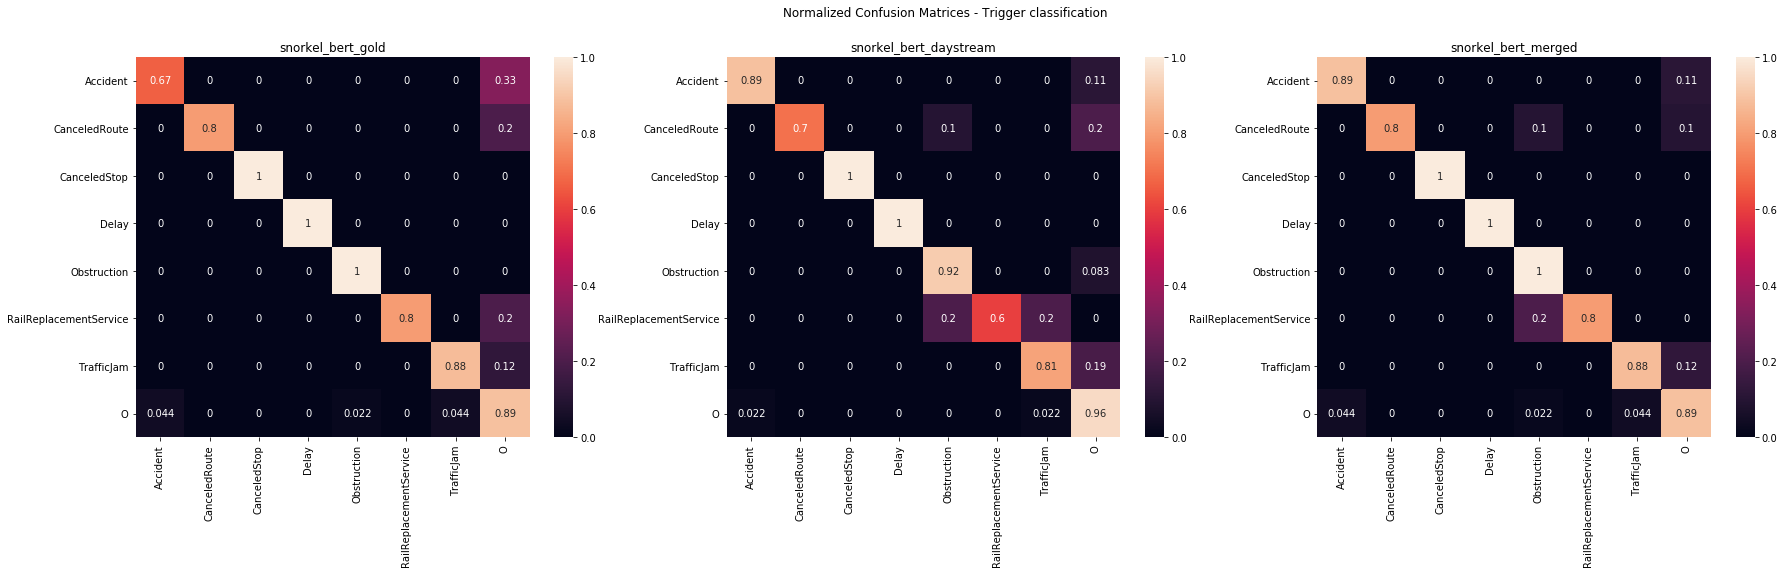

In [14]:
f, axes = plt.subplots(1, 3, figsize=(30,7))
f.suptitle('Normalized Confusion Matrices - Trigger classification')
for i, model_name in enumerate(model_names):
    
    cm = sklearn.metrics.confusion_matrix(trigger_y_true, trigger_y_pred[model_name], labels=SD4M_RELATION_TYPES)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = SD4M_RELATION_TYPES, columns = SD4M_RELATION_TYPES)
    sns.heatmap(df_cm, ax=axes[i], annot=True)
    axes[i].set_title(model_name)

### Argument role classification

In [15]:
print(sklearn.metrics.classification_report(arg_y_true, arg_y_pred["snorkel_bert_gold"], ROLE_LABELS[:-1]))

              precision    recall  f1-score   support

    location       0.83      0.63      0.72        84
       delay       1.00      0.88      0.93         8
   direction       0.88      0.68      0.76        31
   start_loc       0.82      0.79      0.81        39
     end_loc       0.69      0.82      0.75        38
  start_date       1.00      0.22      0.36         9
    end_date       0.50      0.50      0.50         2
       cause       0.71      0.80      0.75        15
  jam_length       1.00      1.00      1.00        13
       route       0.75      1.00      0.86         3

   micro avg       0.81      0.72      0.76       242
   macro avg       0.82      0.73      0.74       242
weighted avg       0.82      0.72      0.75       242



In [16]:
print(sklearn.metrics.classification_report(arg_y_true, arg_y_pred["snorkel_bert_daystream"], ROLE_LABELS[:-1]))

              precision    recall  f1-score   support

    location       0.80      0.48      0.60        84
       delay       0.00      0.00      0.00         8
   direction       0.83      0.77      0.80        31
   start_loc       0.80      0.82      0.81        39
     end_loc       0.88      0.74      0.80        38
  start_date       0.70      0.78      0.74         9
    end_date       1.00      1.00      1.00         2
       cause       1.00      0.73      0.85        15
  jam_length       0.93      1.00      0.96        13
       route       1.00      0.33      0.50         3

   micro avg       0.84      0.65      0.73       242
   macro avg       0.79      0.67      0.71       242
weighted avg       0.81      0.65      0.71       242



/Users/phuc/opt/miniconda3/envs/eventx/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
print(sklearn.metrics.classification_report(arg_y_true, arg_y_pred["snorkel_bert_merged"], ROLE_LABELS[:-1]))

              precision    recall  f1-score   support

    location       0.85      0.68      0.75        84
       delay       0.89      1.00      0.94         8
   direction       0.88      0.74      0.81        31
   start_loc       0.79      0.87      0.83        39
     end_loc       0.76      0.84      0.80        38
  start_date       1.00      0.33      0.50         9
    end_date       1.00      0.50      0.67         2
       cause       0.67      0.80      0.73        15
  jam_length       0.93      1.00      0.96        13
       route       0.75      1.00      0.86         3

   micro avg       0.82      0.77      0.79       242
   macro avg       0.85      0.78      0.78       242
weighted avg       0.83      0.77      0.79       242



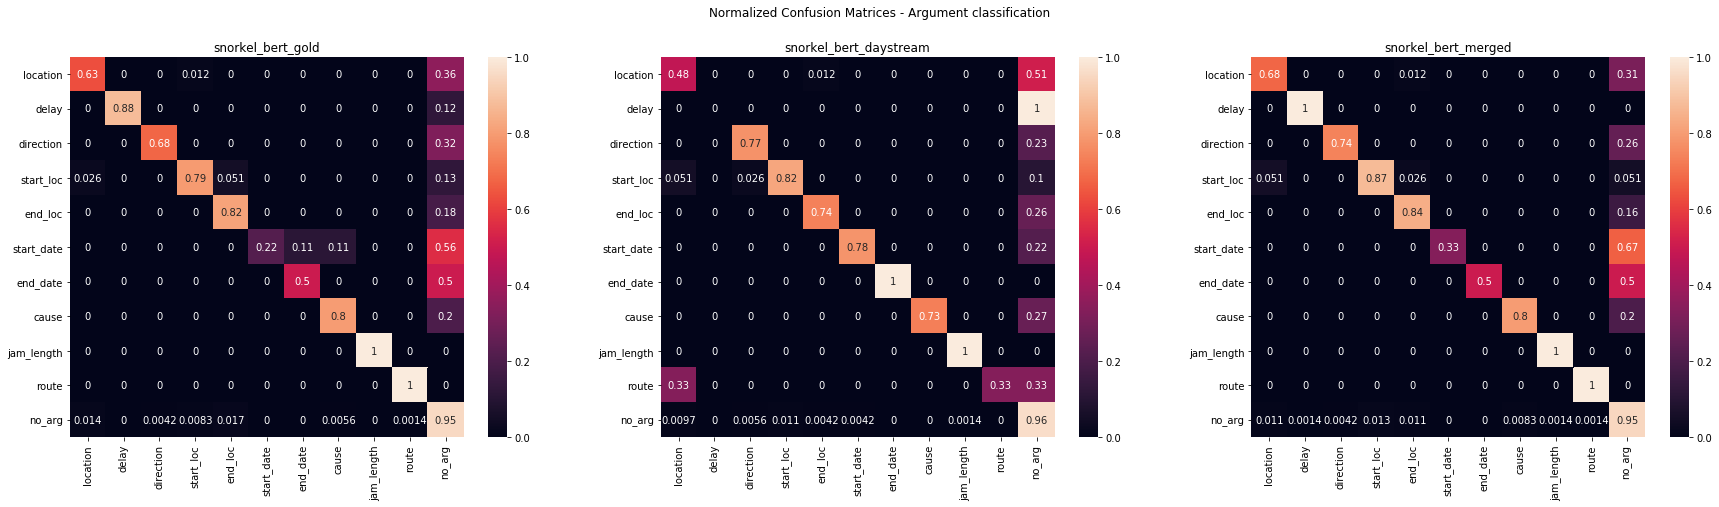

In [18]:
f, axes = plt.subplots(1, 3, figsize=(30,7))
f.suptitle('Normalized Confusion Matrices - Argument classification')
for i, model_name in enumerate(model_names):
    
    cm = sklearn.metrics.confusion_matrix(arg_y_true, arg_y_pred[model_name], labels=ROLE_LABELS)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=ROLE_LABELS, columns=ROLE_LABELS)
    sns.heatmap(df_cm, ax=axes[i], annot=True)
    axes[i].set_title(model_name)

## Event extraction evaluation using correctness criteria defined by Ji, Heng and Grishman, Ralph 2008

Ji, Heng and Grishman, Ralph (2008). Refining event extraction through cross-document inference.
> - A trigger is correctly labeled if its event type and offsets match a reference trigger.
> - An argument is correctly identified if its event type and offsets match any of the reference argument mentions.
> - An argument is correctly identified and classified if its event type, offsets, and role match any of the reference argument mentions.

The main difference to the previous evaluation method lies in the correctness criteria for the arguments. Here we additionally consider the correctness of the event type for the argument.

Caution:
Using the following methods to retrieve the triggers and arguments from the gold data might result in duplicate gold triggers & arguments.
This is due to different events possibly sharing the same trigger.
The model is not able to distinguish such events and instead fuses them all together, which results in lower recall.
If we remove duplicates from the gold triggers and gold arguments, recall and consequently f1 should be higher.

In [19]:
REMOVE_DUPLICATES = True  # change to False if you want to keep duplicate triggers/ arguments from the gold data caused by events sharing the same trigger

In [20]:
gold_triggers = scorer.get_triggers(test_docs)
gold_arguments = scorer.get_arguments(test_docs)

In [21]:
if REMOVE_DUPLICATES:
    gold_triggers = list(set(gold_triggers))
    gold_arguments = list(set(gold_arguments))

In [22]:
pred_triggers = {}
pred_arguments = {}
for model_name in model_names:
    pred_triggers[model_name] = scorer.get_triggers(predicted_docs[model_name])
    pred_arguments[model_name] = scorer.get_arguments(predicted_docs[model_name])

In [23]:
for model_name in model_names:
    print(model_name)
    trigger_id_metrics = scorer.get_trigger_identification_metrics(gold_triggers, pred_triggers[model_name], output_string=True)
    print('\n')

snorkel_bert_gold
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Trigger identification              0.91      0.86      0.88        57


snorkel_bert_daystream
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Trigger identification              0.96      0.88      0.92        57


snorkel_bert_merged
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Trigger identification              0.91      0.93      0.92        57




In [24]:
for model_name in model_names:
    print(model_name)
    trigger_class_metrics = scorer.get_trigger_classification_metrics(gold_triggers, pred_triggers[model_name], output_string=True)
    print('\n')

snorkel_bert_gold
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Trigger classification              0.91      0.86      0.88        57
Accident                            0.75      0.67      0.71         9
CanceledRoute                       1.00      0.80      0.89        10
CanceledStop                        1.00      1.00      1.00         3
Delay                               1.00      1.00      1.00         2
Obstruction                         0.92      1.00      0.96        12
RailReplacementService              1.00      0.80      0.89         5
TrafficJam                          0.88      0.88      0.88        16


snorkel_bert_daystream
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
----

In [25]:
for model_name in model_names:
    print(model_name)
    argument_id_metrics = scorer.get_argument_identification_metrics(gold_arguments, pred_arguments[model_name], output_string=True)
    print('\n')

snorkel_bert_gold
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Argument identification             0.83      0.74      0.78       244


snorkel_bert_daystream
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Argument identification             0.83      0.64      0.72       244


snorkel_bert_merged
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Argument identification             0.82      0.77      0.79       244




In [26]:
for model_name in model_names:
    print(model_name)
    argument_class_metrics = scorer.get_argument_classification_metrics(gold_arguments, pred_arguments[model_name], output_string=True)
    print('\n')

snorkel_bert_gold
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Argument classification             0.81      0.71      0.76       244
location                            0.83      0.63      0.72        84
delay                               1.00      0.88      0.93         8
direction                           0.88      0.68      0.76        31
start_loc                           0.82      0.79      0.81        39
end_loc                             0.69      0.79      0.74        39
start_date                          1.00      0.22      0.36         9
end_date                            0.50      0.33      0.40         3
cause                               0.71      0.80      0.75        15
jam_length                          1.00      1.00      1.00        13
route                               0.7

### 5 Random Repeats
5 random repeats for each configuration with random seeds for the snorkel label models and eventx model.
Metrics are given as median & standard deviation.

In [27]:
model_base_path = Path("../../data/runs/random_repeats")
runs = 5
trigger_metrics_rr, argument_metrics_rr = {}, {}
for model_name in model_names:
    print(model_name)
    model_paths = [model_base_path.joinpath(f'run0{run+1}/{model_name}') for run in range(runs)]
    trigger_metrics_rr[model_name], argument_metrics_rr[model_name] = evaluate.summize_multiple_runs(model_paths, test_docs)
    formatted_trigger = evaluate.format_classification_report(evaluate.get_median_std(trigger_metrics_rr[model_name]), make_string=True)
    formatted_argument = evaluate.format_classification_report(evaluate.get_median_std(argument_metrics_rr[model_name]), make_string=True)
    formatted_metrics = pd.concat([formatted_trigger, formatted_argument])
    formatted_metrics.set_index('row_name', inplace=True)
    display(formatted_metrics.loc[['Trigger identification', 'Trigger classification', 'Argument identification', 'Argument classification']])
    print('\n')

snorkel_bert_gold


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,92.5+/- 0.7,89.5+/- 1.4,90.3+/- 0.6,57
Trigger classification,90.9+/- 1.7,87.7+/- 1.8,89.3+/- 1.5,57
Argument identification,81.6+/- 1.8,76.6+/- 3.4,78.1+/- 1.8,244
Argument classification,79.1+/- 1.8,74.2+/- 3.2,75.6+/- 1.8,244




snorkel_bert_daystream


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,92.0+/- 2.6,82.5+/- 3.0,87.3+/- 2.3,57
Trigger classification,88.0+/- 2.4,78.9+/- 3.3,82.2+/- 2.5,57
Argument identification,84.8+/- 3.5,63.1+/- 4.6,72.3+/- 2.9,244
Argument classification,82.3+/- 4.9,60.7+/- 3.5,66.2+/- 2.6,244




snorkel_bert_merged


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,92.9+/- 0.7,91.2+/- 1.8,92.0+/- 1.1,57
Trigger classification,89.7+/- 2.3,87.7+/- 2.0,89.3+/- 2.0,57
Argument identification,85.8+/- 3.1,80.7+/- 2.1,83.2+/- 2.4,244
Argument classification,83.5+/- 3.3,78.7+/- 2.2,80.7+/- 2.5,244


5 random repeats for each configuration with random seeds for the eventx model. We kept used the same training data for each run, i.e. did not use random seeds for the snorkel labeling.
Metrics are given as median & standard deviation.

In [28]:
model_base_path = Path("../../data/runs/random_repeats_fixed_daystream")
runs = 5
trigger_metrics_rrd, argument_metrics_rrd = {}, {}
for model_name in model_names:
    print(model_name)
    model_paths = [model_base_path.joinpath(f'run_{run+1}/{model_name}') for run in range(runs)]
    trigger_metrics_rrd[model_name], argument_metrics_rrd[model_name] = evaluate.summize_multiple_runs(model_paths, test_docs)
    formatted_trigger = evaluate.format_classification_report(evaluate.get_median_std(trigger_metrics_rrd[model_name]), make_string=True)
    formatted_argument = evaluate.format_classification_report(evaluate.get_median_std(argument_metrics_rrd[model_name]), make_string=True)
    formatted_metrics = pd.concat([formatted_trigger, formatted_argument])
    formatted_metrics.set_index('row_name', inplace=True)
    display(formatted_metrics.loc[['Trigger identification', 'Trigger classification', 'Argument identification', 'Argument classification']])
    print('\n')

snorkel_bert_gold


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,92.5+/- 0.7,89.5+/- 1.4,90.3+/- 0.6,57
Trigger classification,90.9+/- 1.7,87.7+/- 1.8,89.3+/- 1.5,57
Argument identification,81.6+/- 1.8,76.6+/- 3.4,78.1+/- 1.8,244
Argument classification,79.1+/- 1.8,74.2+/- 3.2,75.6+/- 1.8,244




snorkel_bert_daystream


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,94.5+/- 0.9,82.5+/- 3.9,88.7+/- 2.2,57
Trigger classification,89.1+/- 2.3,77.2+/- 4.0,83.0+/- 2.7,57
Argument identification,83.2+/- 0.8,61.1+/- 2.4,70.8+/- 1.7,244
Argument classification,80.7+/- 1.1,59.8+/- 2.3,68.7+/- 1.7,244




snorkel_bert_merged


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,93.0+/- 1.3,91.2+/- 1.8,92.9+/- 1.3,57
Trigger classification,91.2+/- 1.8,91.2+/- 1.8,91.2+/- 1.6,57
Argument identification,86.8+/- 3.4,79.9+/- 2.9,81.9+/- 2.1,244
Argument classification,83.8+/- 3.5,78.3+/- 2.5,80.9+/- 1.9,244


### Scalability of snorkel labeled data
Compare model performance with increasing amount of snorkel labeled data.
We sample 50%, 60%, ..., 100% from the Daystream data. We do this 6 times and look at the median f1-score to reduce the chance of getting outliers (lucky samples) during the sampling process.
We encountered OOV errors for the models that were trained with less of the training data. We omit the test scores of these models and report how many scores were used per sample size to calculate the median.

Sample sizes and how many test scores:
- 50%: sample runs 3, 4, 6
- 60%: sample runs 1, 4-6 
- 70%: sample runs 2-6
- 80%: sample runs 1, 3-6
- 90%: sample runs 1-6
- 100%: sample runs 1-6

In [29]:
# increasing training data over 5 different sample runs: getting a bunch of entity_tags vocabulary key errors (removed from evaluation)
model_names = [f'daystream{percentage}_snorkeled' for percentage in range(50,101,10)]
model_base_path = Path("../../data/runs/increasing_train_data")
runs = 6
trigger_metrics, argument_metrics = {}, {}
for model_name in model_names:
    print(model_name)
    model_paths = [model_base_path.joinpath(f'samples_{run+1}/{model_name}') for run in range(runs)]
    trigger_metrics[model_name], argument_metrics[model_name] = evaluate.summize_multiple_runs(model_paths, test_docs)

daystream50_snorkeled


ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-26 20:38:17,348 - The model ../../data/runs/increasing_train_data/samples_1/daystream50_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.
ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-26 20:38:21,745 - The model ../../data/runs/increasing_train_data/samples_2/daystream50_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.
ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-26 20:39:01,691 - The model ../../data/runs/increasing_train_data/samples_5/daystream50_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.


daystream60_snorkeled


ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-26 20:39:41,364 - The model ../../data/runs/increasing_train_data/samples_2/daystream60_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.
ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-26 20:39:45,574 - The model ../../data/runs/increasing_train_data/samples_3/daystream60_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.


daystream70_snorkeled


ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-26 20:40:43,247 - The model ../../data/runs/increasing_train_data/samples_1/daystream70_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.


daystream80_snorkeled


ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-26 20:42:35,309 - The model ../../data/runs/increasing_train_data/samples_2/daystream80_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.


daystream90_snorkeled
daystream100_snorkeled


In [30]:
def get_infos(metrics, metric_name, labels=None):
    table = []
    for idx, (k,v) in enumerate(metrics.items()):
        if labels is None:
            tmp = {'Model': k}
        else:
            tmp = {'Sample size in %': labels[idx]}
        tmp[metric_name] = np.median(v[metric_name]['f1-score'])
        table.append(tmp)
    if labels is None:
        return pd.DataFrame(table).set_index('Model')
    else:
        return pd.DataFrame(table).set_index('Sample size in %')

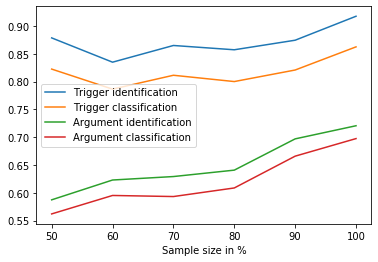

In [31]:
sample_sizes = [percentage for percentage in range(50,101,10)]
progression_table = get_infos(trigger_metrics, 'Trigger identification', labels=sample_sizes)
progression_table = progression_table.merge(get_infos(trigger_metrics, 'Trigger classification', labels=sample_sizes), left_index=True, right_index=True)
progression_table = progression_table.merge(get_infos(argument_metrics, 'Argument identification', labels=sample_sizes), left_index=True, right_index=True)
progression_table = progression_table.merge(get_infos(argument_metrics, 'Argument classification', labels=sample_sizes), left_index=True, right_index=True)
progression_table.plot()

In [32]:
for model_name in model_names:
    print(model_name)
    formatted_trigger = evaluate.format_classification_report(evaluate.get_median_std(trigger_metrics[model_name]), make_string=True)
    formatted_argument = evaluate.format_classification_report(evaluate.get_median_std(argument_metrics[model_name]), make_string=True)
    formatted_metrics = pd.concat([formatted_trigger, formatted_argument])
    formatted_metrics.set_index('row_name', inplace=True)
    display(formatted_metrics.loc[['Trigger identification', 'Trigger classification', 'Argument identification', 'Argument classification']])
    print('\n')

daystream50_snorkeled


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,90.6+/- 2.0,84.2+/- 2.2,87.9+/- 0.5,57
Trigger classification,85.7+/- 2.9,77.2+/- 3.8,82.2+/- 2.8,57
Argument identification,74.2+/- 3.3,47.5+/- 4.4,58.7+/- 3.8,244
Argument classification,70.2+/- 5.3,45.5+/- 5.2,56.2+/- 5.1,244




daystream60_snorkeled


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,92.7+/- 1.2,75.4+/- 4.5,83.5+/- 3.0,57
Trigger classification,86.6+/- 1.9,71.1+/- 4.5,78.6+/- 3.2,57
Argument identification,81.0+/- 3.2,51.0+/- 3.1,62.3+/- 2.5,244
Argument classification,77.3+/- 5.0,48.0+/- 3.5,59.5+/- 3.5,244




daystream70_snorkeled


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,90.6+/- 1.8,82.5+/- 4.0,86.5+/- 2.7,57
Trigger classification,84.9+/- 2.9,77.2+/- 4.6,81.1+/- 3.6,57
Argument identification,76.2+/- 4.6,57.4+/- 3.9,62.9+/- 3.5,244
Argument classification,71.4+/- 6.2,54.1+/- 5.5,59.3+/- 5.4,244




daystream80_snorkeled


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,92.2+/- 2.6,78.9+/- 5.7,85.7+/- 4.0,57
Trigger classification,86.3+/- 4.7,73.7+/- 6.7,80.0+/- 5.6,57
Argument identification,73.1+/- 4.1,57.4+/- 1.5,64.1+/- 1.4,244
Argument classification,69.2+/- 4.2,54.5+/- 1.2,60.9+/- 1.4,244




daystream90_snorkeled


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,93.1+/- 2.8,81.6+/- 3.8,87.4+/- 3.1,57
Trigger classification,88.1+/- 2.6,76.3+/- 3.5,82.1+/- 2.9,57
Argument identification,81.0+/- 2.2,61.5+/- 2.1,69.7+/- 2.0,244
Argument classification,77.3+/- 2.2,58.8+/- 2.2,66.6+/- 2.2,244




daystream100_snorkeled


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,96.2+/- 0.0,87.7+/- 0.0,91.7+/- 0.0,57
Trigger classification,90.4+/- 0.0,82.5+/- 0.0,86.2+/- 0.0,57
Argument identification,82.5+/- 0.0,63.9+/- 0.0,72.1+/- 0.0,244
Argument classification,79.9+/- 0.0,61.9+/- 0.0,69.7+/- 0.0,244
